# Diabetes Challenge

Your task today is to **analyze** the Kaggle "Pima Indians Diabetes Database" and to **predict** whether a patient has Diabetes or not.

## Task:
- Load the data from the database. The schema is called `diabetes`. To connect to the database you need to copy the `.env` file from the visualization or hands-on-ml repository into this repo. Explore the database, try to establish what the relationships between the tables are (1-1, 1-N, N-M). Explain to yourself and the group what data do you see and whether it makes sense. What JOINs are appropriate to use and why? 
- Use at least two different classification algorithms we have learned so far to predict Diabetes patients. 
- Discuss before you start with the modeling process which **evaluation metric** you choose and explain why.
- Implement a GridSearchCV or RandomizedSearchCV to tune the hyperparameters of your model.
- **Optional:** If you have time at the end, try to use sklearn's pipline module to encapsulate all the steps into a pipeline.

Don't forget to split your data in train and test set. And analyze your final model on the test data. It might also be necessary to scale your data in order to improve the performance of some of the models.

`
## Helpful links and advise:
- [sklearn documentation on hyperparameter tuning](https://scikit-learn.org/stable/modules/grid_search.html#grid-search)
- It might be helpful to check some sources on how to deal with imbalanced data. 
    * [8 Tactics to Combat Imbalanced Classes](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/)
    * [Random-Oversampling/Undersampling](https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/)


# Data Description

## Context
This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

## Acknowledgements
Smith, J.W., Everhart, J.E., Dickson, W.C., Knowler, W.C., & Johannes, R.S. (1988). Using the ADAP learning algorithm to forecast the onset of diabetes mellitus. In Proceedings of the Symposium on Computer Applications and Medical Care (pp. 261--265). IEEE Computer Society Press.

## About this dataset
The datasets consist of several medical predictor (independent) variables and one target (dependent) variable, Outcome. Independent variables include the number of pregnancies the patient has had, their BMI, insulin level, age, and so on. For the outcome class value 1 is interpreted as "tested positive for diabetes".

|Column Name| Description|
|:------------|:------------|
|Pregnancies|Number of times pregnant|
|Glucose|Plasma glucose concentration a 2 hours in an oral glucose tolerance test|
|BloodPressure|Diastolic blood pressure (mm Hg)|
|SkinThickness|Triceps skin fold thickness (mm)|
|Insulin|2-Hour serum insulin (mu U/ml)|
|BMI|Body mass index (weight in kg/(height in m)^2)|
|DiabetesPedigreeFunction| Diabetes pedigree function|
|Age| Age (years)|
|Outcome|Class variable (0 or 1) |

In [29]:
# Import of relevant packages

import os
from dotenv import load_dotenv
from sqlalchemy import create_engine

import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Set random seed 
RSEED = 42
warnings.filterwarnings("ignore")

## Load data from database

In [30]:
# Read database string from .env file (no need to change anything)
load_dotenv()

DB_STRING = os.getenv('DB_STRING')

db = create_engine(DB_STRING)

In [31]:
# Define query to download data (add your query here)
query_string = ''' 
set SCHEMA 'diabetes';
SELECT
    p.id as patient_id,
    bm1.glucose as glucose_1,
    bm1.insulin as insulin_1,
    bm1.bloodpressure as blood_pressure_1,
    bm2.glucose as glucose_13,
    bm2.insulin as insulin_13,
    bm2.bloodpressure as blood_pressure_13,
    p."Age" as age,
    p.pregnancies,
    p.bmi,
    s.skinthickness as skin_thickness,
    po.diabetespedigreefunction as diabetes_pedigree_function,
    po.outcome
FROM patient p
LEFT JOIN blood_metrics bm1 ON p.id = bm1.patientid 
    AND bm1.measurement_date = (
        SELECT MIN(measurement_date) 
        FROM blood_metrics 
        WHERE patientid = p.id
    )
LEFT JOIN blood_metrics bm2 ON p.id = bm2.patientid 
    AND bm2.measurement_date = (
        SELECT MAX(measurement_date) 
        FROM blood_metrics 
        WHERE patientid = p.id
    )
INNER JOIN skin s ON s.patientid = p.id
INNER JOIN pedigree_outcome po ON po.patientid = p.id;
'''

# Import with pandas
df_sqlalchemy = pd.read_sql(query_string, db)
df_sqlalchemy.head()

,patient_id,glucose_1,insulin_1,blood_pressure_1,glucose_13,insulin_13,blood_pressure_13,age,pregnancies,bmi,skin_thickness,diabetes_pedigree_function,outcome
0,1,172,80,117,148,0,72,50,6,33.6,35,0.627,1
1,2,54,80,93,85,0,66,31,1,26.6,29,0.351,0
2,3,168,1,100,183,0,64,32,8,23.3,0,0.672,1
3,4,53,26,39,89,94,66,21,1,28.1,23,0.167,0
4,5,184,54,116,137,168,40,33,0,43.1,35,2.288,1


In [32]:
if not os.path.exists("./data"):
    os.mkdir("data")

In [33]:
# Save dataframe as .csv file
df_sqlalchemy.to_csv("data/diabetes_data.csv", index=False)

In [34]:
df = pd.read_csv('data/diabetes_data.csv')
df.head()

,patient_id,glucose_1,insulin_1,blood_pressure_1,glucose_13,insulin_13,blood_pressure_13,age,pregnancies,bmi,skin_thickness,diabetes_pedigree_function,outcome
0,1,172,80,117,148,0,72,50,6,33.6,35,0.627,1
1,2,54,80,93,85,0,66,31,1,26.6,29,0.351,0
2,3,168,1,100,183,0,64,32,8,23.3,0,0.672,1
3,4,53,26,39,89,94,66,21,1,28.1,23,0.167,0
4,5,184,54,116,137,168,40,33,0,43.1,35,2.288,1


In [35]:
#Print the shape of the data
print('Diabetes dataset')
print('==================')
print('# observations: {}'.format(df.shape[0]))
print('# features:     {}'.format(df.shape[1]-1))

Diabetes dataset
# observations: 768
# features:     12


## Data Investigation

In [36]:
# Getting an idea of the dimension
print('Number of rows and columns of train: ',df.shape)

Number of rows and columns of train:  (768, 13)


In [37]:
# Inspecting the type of features
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   patient_id                  768 non-null    int64  
 1   glucose_1                   768 non-null    int64  
 2   insulin_1                   768 non-null    int64  
 3   blood_pressure_1            768 non-null    int64  
 4   glucose_13                  768 non-null    int64  
 5   insulin_13                  768 non-null    int64  
 6   blood_pressure_13           768 non-null    int64  
 7   age                         768 non-null    int64  
 8   pregnancies                 768 non-null    int64  
 9   bmi                         768 non-null    float64
 10  skin_thickness              768 non-null    int64  
 11  diabetes_pedigree_function  768 non-null    float64
 12  outcome                     768 non-null    int64  
dtypes: float64(2), int64(11)
memory usa

In [38]:
# Having a look at some simple, descriptive statistics 
df.describe().round(2)

,patient_id,glucose_1,insulin_1,blood_pressure_1,glucose_13,insulin_13,blood_pressure_13,age,pregnancies,bmi,skin_thickness,diabetes_pedigree_function,outcome
count,768.00,768.00,768.00,768.00,768.00,768.00,768.00,768.00,768.00,768.00,768.00,768.00,768.00
mean,384.50,102.00,48.41,63.05,120.89,79.80,69.11,33.24,3.85,31.99,20.54,0.47,0.35
std,221.85,58.33,29.32,35.41,31.97,115.24,19.36,11.76,3.37,7.88,15.95,0.33,0.48
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00,21.00,0.00,0.00,0.00,0.08,0.00
25%,192.75,52.75,22.00,32.00,99.00,0.00,62.00,24.00,1.00,27.30,0.00,0.24,0.00
50%,384.50,105.00,49.00,62.00,117.00,30.50,72.00,29.00,3.00,32.00,23.00,0.37,0.00
75%,576.25,152.00,73.00,96.00,140.25,127.25,80.00,41.00,6.00,36.60,32.00,0.63,1.00
max,768.00,200.00,100.00,122.00,199.00,846.00,122.00,81.00,17.00,67.10,99.00,2.42,1.00


In [39]:
# How many unique entries do the features have?
df.nunique()

patient_id                    768
glucose_1                     196
insulin_1                     101
blood_pressure_1              123
glucose_13                    136
insulin_13                    186
blood_pressure_13              47
age                            52
pregnancies                    17
bmi                           248
skin_thickness                 51
diabetes_pedigree_function    517
outcome                         2
dtype: int64

In [40]:
# Checking for missing values
df.isnull().sum()

patient_id                    0
glucose_1                     0
insulin_1                     0
blood_pressure_1              0
glucose_13                    0
insulin_13                    0
blood_pressure_13             0
age                           0
pregnancies                   0
bmi                           0
skin_thickness                0
diabetes_pedigree_function    0
outcome                       0
dtype: int64

# Plot Data:


TARGET VARIABLE ANALYSIS


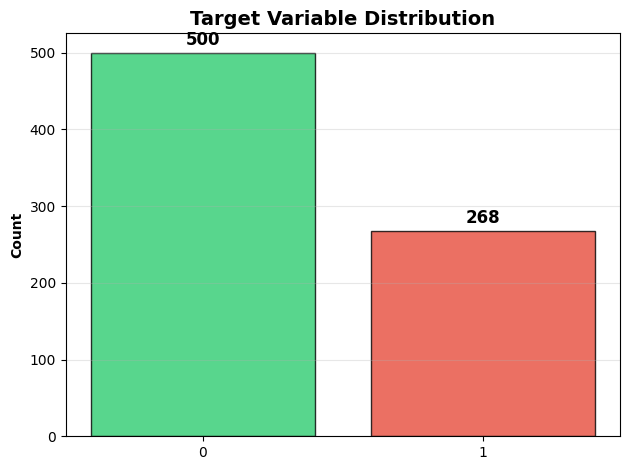


Class Distribution:
  No Diabetes (0): 500 (65.1%)
  Diabetes (1): 268 (34.9%)
  Imbalance Ratio: 1.87:1
Dataset is imbalanced - consider using F1 score or stratified sampling


In [41]:
print("\n" + "="*80)
print("TARGET VARIABLE ANALYSIS")
print("="*80)

# Plot 1: Count plot
outcome_counts = df['outcome'].value_counts()
colors_outcome = ['#2ecc71', '#e74c3c']
plt.bar(outcome_counts.index, outcome_counts.values, color=colors_outcome, alpha=0.8, edgecolor='black')
plt.xticks([0, 1])
plt.ylabel('Count', fontweight='bold')
plt.title('Target Variable Distribution', fontweight='bold', fontsize=14)
plt.grid(True, alpha=0.3, axis='y')

# Add value labels
for i, (idx, val) in enumerate(zip(outcome_counts.index, outcome_counts.values)):
    plt.text(idx, val + 5, str(val), ha='center', va='bottom', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()

# Class imbalance check
print(f"\nClass Distribution:")
print(f"  No Diabetes (0): {outcome_counts[0]} ({outcome_counts[0]/len(df)*100:.1f}%)")
print(f"  Diabetes (1): {outcome_counts[1]} ({outcome_counts[1]/len(df)*100:.1f}%)")
print(f"  Imbalance Ratio: {outcome_counts[0]/outcome_counts[1]:.2f}:1")

if outcome_counts[0]/outcome_counts[1] > 1.5:
    print(f"Dataset is imbalanced - consider using F1 score or stratified sampling")

## Day 1 and Day 13 data visualization:


DISTRIBUTION ANALYSIS: DAY 1 vs DAY 13


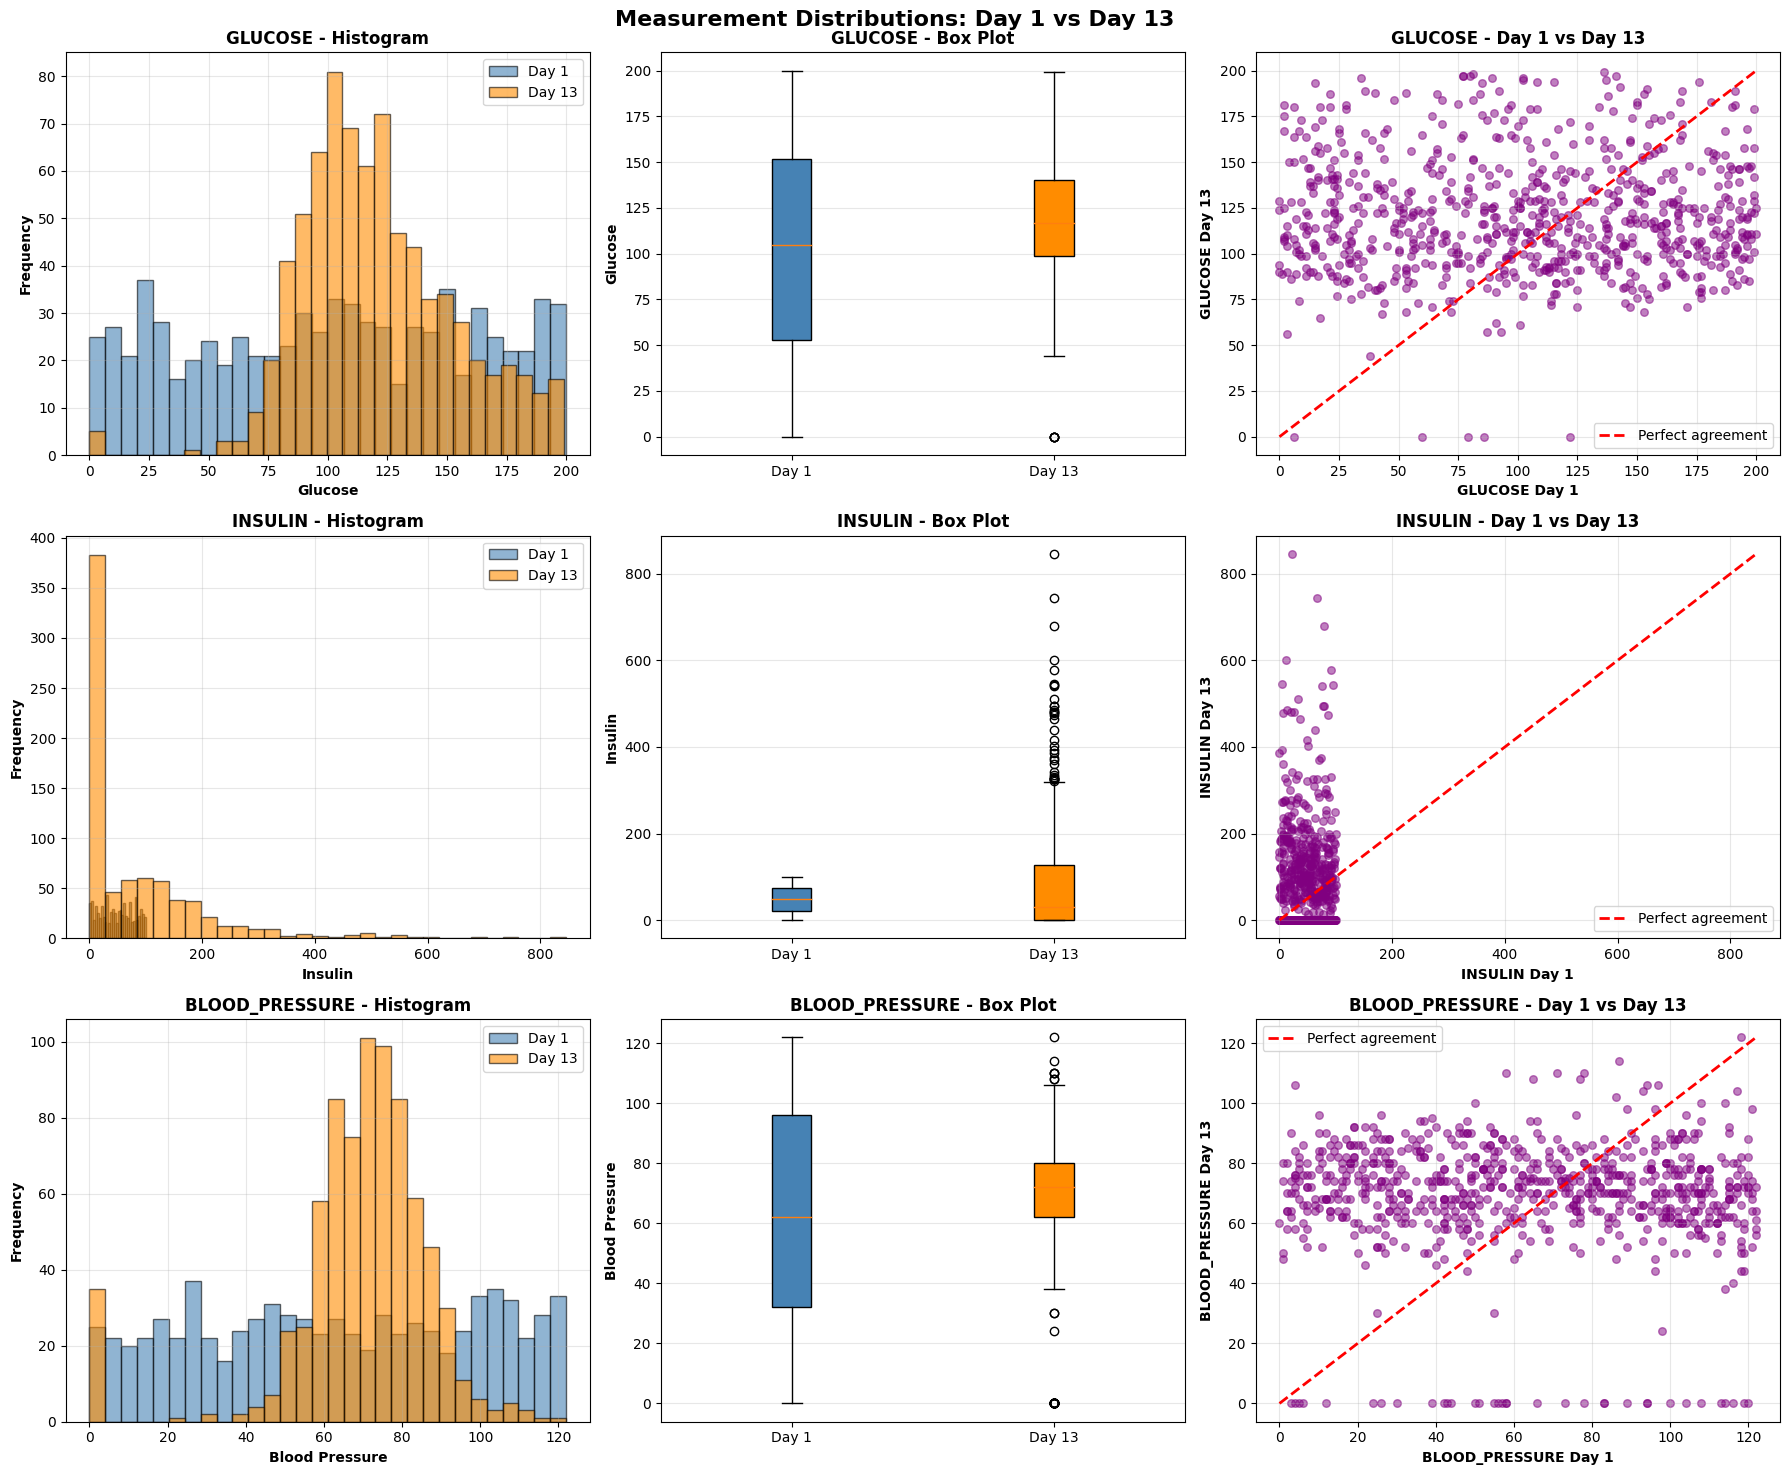

In [42]:
print("\n" + "="*80)
print("DISTRIBUTION ANALYSIS: DAY 1 vs DAY 13")
print("="*80)

measurements = ['glucose', 'insulin', 'blood_pressure']
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
fig.suptitle('Measurement Distributions: Day 1 vs Day 13', fontsize=16, fontweight='bold')

for idx, measure in enumerate(measurements):
    day1_col = f'{measure}_1'
    day13_col = f'{measure}_13'
    
    # Histogram
    ax1 = axes[idx, 0]
    ax1.hist(df[day1_col].dropna(), bins=30, alpha=0.6, label='Day 1', 
             color='steelblue', edgecolor='black')
    ax1.hist(df[day13_col].dropna(), bins=30, alpha=0.6, label='Day 13', 
             color='darkorange', edgecolor='black')
    ax1.set_xlabel(measure.replace('_', ' ').title(), fontweight='bold')
    ax1.set_ylabel('Frequency', fontweight='bold')
    ax1.set_title(f'{measure.upper()} - Histogram', fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Box plot
    ax2 = axes[idx, 1]
    box_data = [df[day1_col].dropna(), df[day13_col].dropna()]
    bp = ax2.boxplot(box_data, labels=['Day 1', 'Day 13'], patch_artist=True,
                     showfliers=True)
    bp['boxes'][0].set_facecolor('steelblue')
    bp['boxes'][1].set_facecolor('darkorange')
    ax2.set_ylabel(measure.replace('_', ' ').title(), fontweight='bold')
    ax2.set_title(f'{measure.upper()} - Box Plot', fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Scatter plot (Day 1 vs Day 13)
    ax3 = axes[idx, 2]
    valid_mask = df[day1_col].notna() & df[day13_col].notna()
    ax3.scatter(df.loc[valid_mask, day1_col], df.loc[valid_mask, day13_col], 
               alpha=0.5, s=30, color='purple')
    
    # Add diagonal line
    max_val = max(df[day1_col].max(), df[day13_col].max())
    ax3.plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect agreement')
    ax3.set_xlabel(f'{measure.upper()} Day 1', fontweight='bold')
    ax3.set_ylabel(f'{measure.upper()} Day 13', fontweight='bold')
    ax3.set_title(f'{measure.upper()} - Day 1 vs Day 13', fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Outliers Detection:


OUTLIER DETECTION AND ANALYSIS


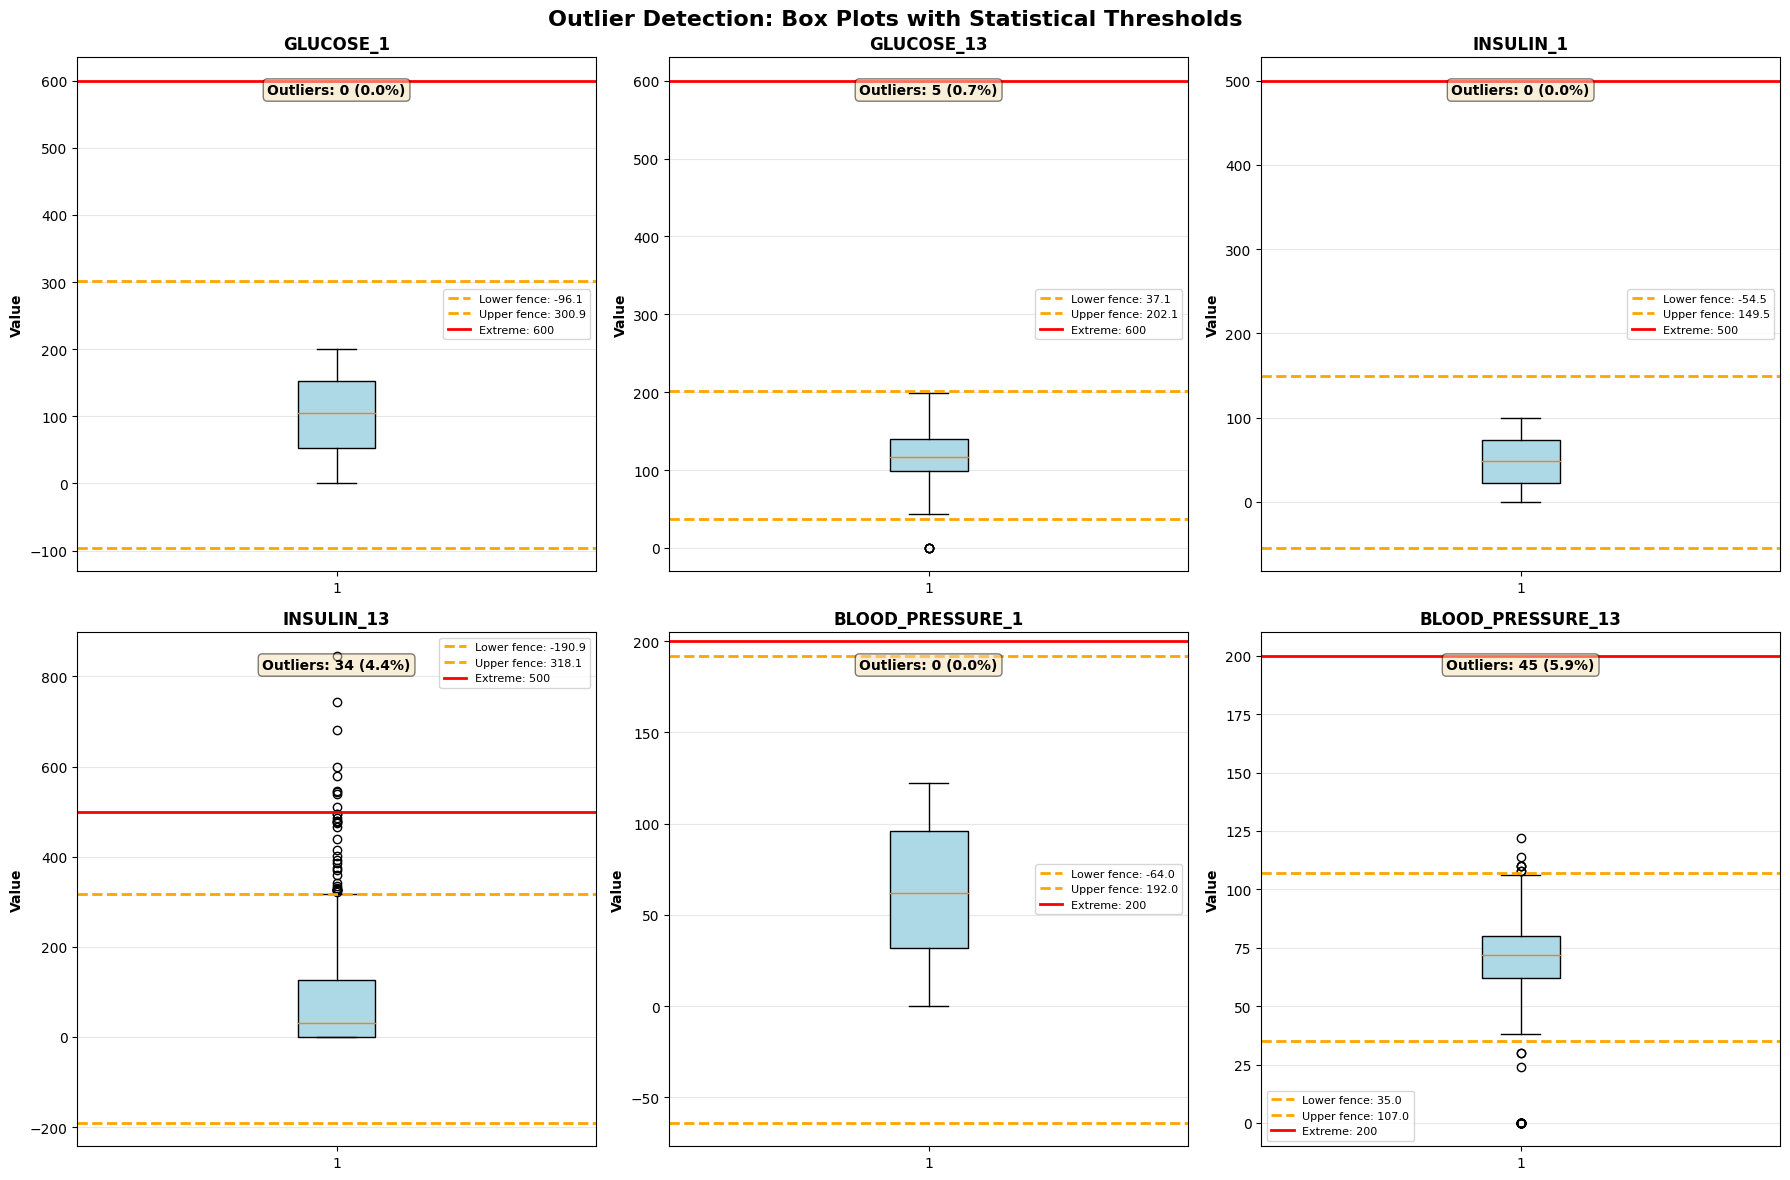


OUTLIER STATISTICS (IQR Method):
------------------------------------------------------------
glucose_1: 0 outliers (0.0%)
glucose_13: 5 outliers (0.7%)
  Range: [0.0, 199.0]
  Outlier range: [0.0, 0.0]
insulin_1: 0 outliers (0.0%)
insulin_13: 34 outliers (4.4%)
  Range: [0.0, 846.0]
  Outlier range: [321.0, 846.0]
blood_pressure_1: 0 outliers (0.0%)
blood_pressure_13: 45 outliers (5.9%)
  Range: [0.0, 122.0]
  Outlier range: [0.0, 122.0]


In [ ]:
print("\n" + "="*80)
print("OUTLIER DETECTION AND ANALYSIS")
print("="*80)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Outlier Detection: Box Plots with Statistical Thresholds', 
             fontsize=16, fontweight='bold')

measurements_all = ['glucose_1', 'glucose_13', 'insulin_1', 
                    'insulin_13', 'blood_pressure_1', 'blood_pressure_13']

for idx, col in enumerate(measurements_all):
    ax = axes[idx // 3, idx % 3]
    
    data = df[col].dropna()
    
    # Calculate statistics
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_fence = Q1 - 1.5 * IQR
    upper_fence = Q3 + 1.5 * IQR
    
    outliers = data[(data < lower_fence) | (data > upper_fence)]
    
    # Box plot
    bp = ax.boxplot([data], patch_artist=True, showfliers=True)
    bp['boxes'][0].set_facecolor('lightblue')
    
    # Add threshold lines
    ax.axhline(y=lower_fence, color='orange', linestyle='--', linewidth=2, 
               label=f'Lower fence: {lower_fence:.1f}')
    ax.axhline(y=upper_fence, color='orange', linestyle='--', linewidth=2, 
               label=f'Upper fence: {upper_fence:.1f}')
    
    # Add extreme threshold for this specific measurement
    if 'insulin' in col:
        ax.axhline(y=500, color='red', linestyle='-', linewidth=2, 
                  label='Extreme: 500')
    elif 'glucose' in col:
        ax.axhline(y=600, color='red', linestyle='-', linewidth=2, 
                  label='Extreme: 600')
    elif 'blood_pressure' in col:
        ax.axhline(y=200, color='red', linestyle='-', linewidth=2, 
                  label='Extreme: 200')
    
    ax.set_title(f'{col.upper()}', fontweight='bold')
    ax.set_ylabel('Value', fontweight='bold')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add text with outlier count
    ax.text(0.5, 0.95, f'Outliers: {len(outliers)} ({len(outliers)/len(data)*100:.1f}%)',
           transform=ax.transAxes, ha='center', va='top',
           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
           fontweight='bold')

plt.tight_layout()
plt.show()

# Print outlier statistics
print("\nOUTLIER STATISTICS (IQR Method):")
print("-" * 60)
for col in measurements_all:
    data = df[col].dropna()
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_fence = Q1 - 1.5 * IQR
    upper_fence = Q3 + 1.5 * IQR
    outliers = data[(data < lower_fence) | (data > upper_fence)]
    
    print(f"{col}: {len(outliers)} outliers ({len(outliers)/len(data)*100:.1f}%)")
    if len(outliers) > 0:
        print(f"  Range: [{data.min():.1f}, {data.max():.1f}]")
        print(f"  Outlier range: [{outliers.min():.1f}, {outliers.max():.1f}]")

## Correlation Analysis:


CORRELATION ANALYSIS


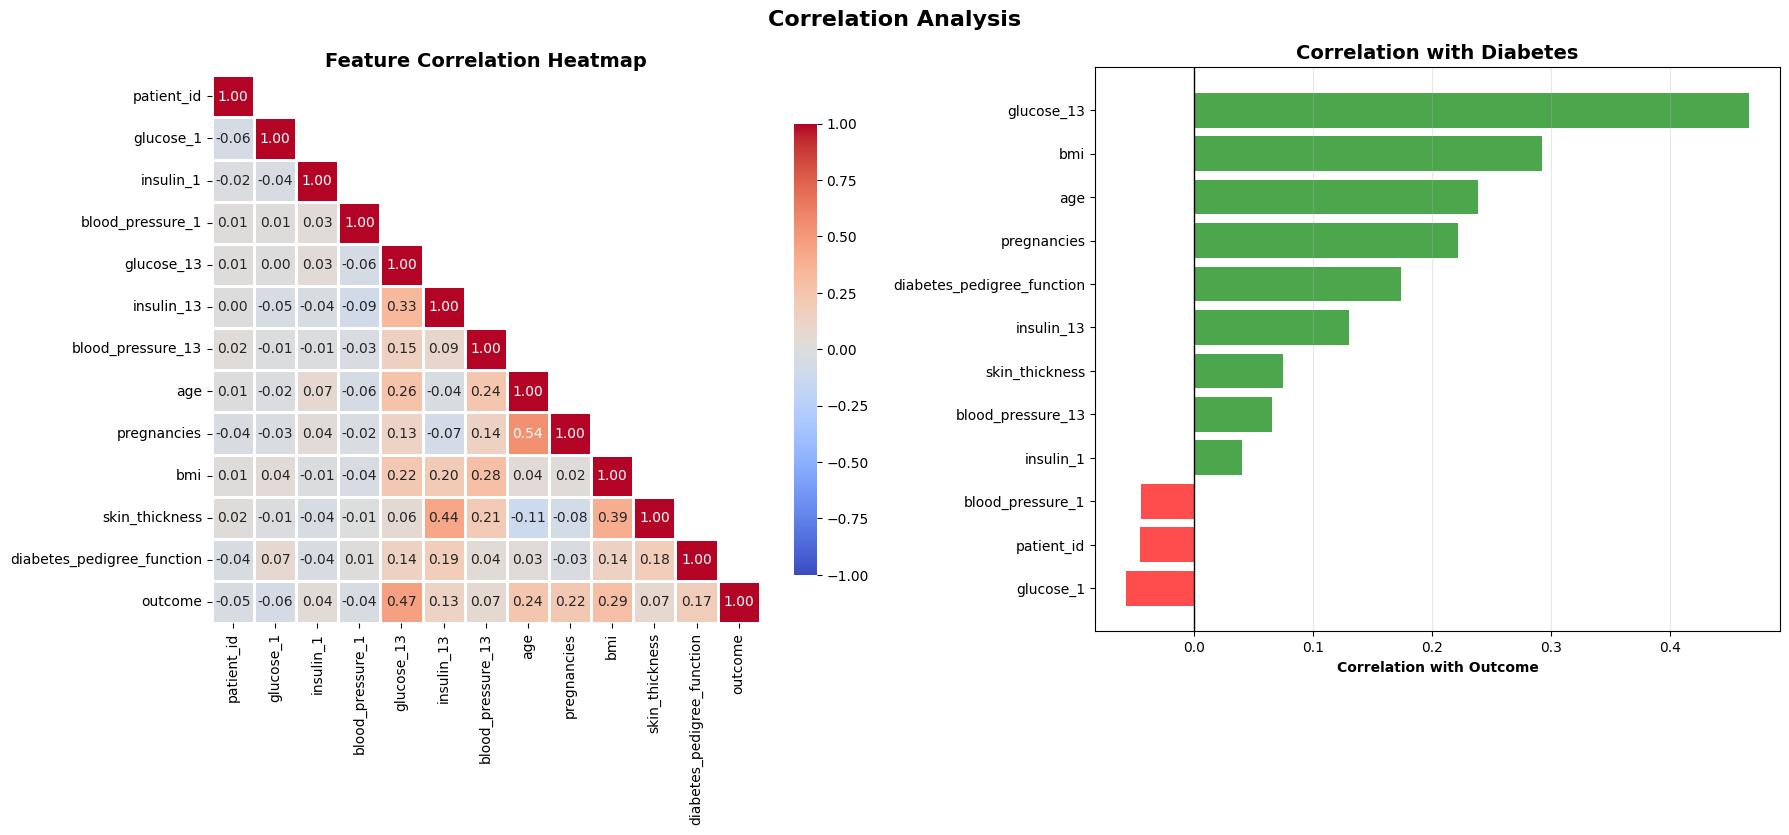


TOP CORRELATIONS WITH OUTCOME:
------------------------------------------------------------
glucose_13               : +0.4666
bmi                      : +0.2927
age                      : +0.2384
pregnancies              : +0.2219
diabetes_pedigree_function: +0.1738


In [44]:
print("\n" + "="*80)
print("CORRELATION ANALYSIS")
print("="*80)

# Calculate correlation matrix
corr_matrix = df.corr()

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
fig.suptitle('Correlation Analysis', fontsize=16, fontweight='bold')

# Plot 1: Correlation heatmap
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=1, 
            cbar_kws={"shrink": 0.8}, ax=axes[0], vmin=-1, vmax=1)
axes[0].set_title('Feature Correlation Heatmap', fontweight='bold', fontsize=14)

# Plot 2: Correlation with outcome
outcome_corr = corr_matrix['outcome'].drop('outcome').sort_values()
colors = ['red' if x < 0 else 'green' for x in outcome_corr.values]
axes[1].barh(outcome_corr.index, outcome_corr.values, color=colors, alpha=0.7)
axes[1].set_xlabel('Correlation with Outcome', fontweight='bold')
axes[1].set_title('Correlation with Diabetes', fontweight='bold', fontsize=14)
axes[1].axvline(x=0, color='black', linestyle='-', linewidth=1)
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# Print top correlations with outcome
print("\nTOP CORRELATIONS WITH OUTCOME:")
print("-" * 60)
outcome_corr_sorted = corr_matrix['outcome'].drop('outcome').abs().sort_values(ascending=False)
for feature in outcome_corr_sorted.head(5).index:
    corr_val = corr_matrix.loc[feature, 'outcome']
    print(f"{feature:25s}: {corr_val:+.4f}")

# Feature Destribution by Outcome:


FEATURE DISTRIBUTIONS BY OUTCOME


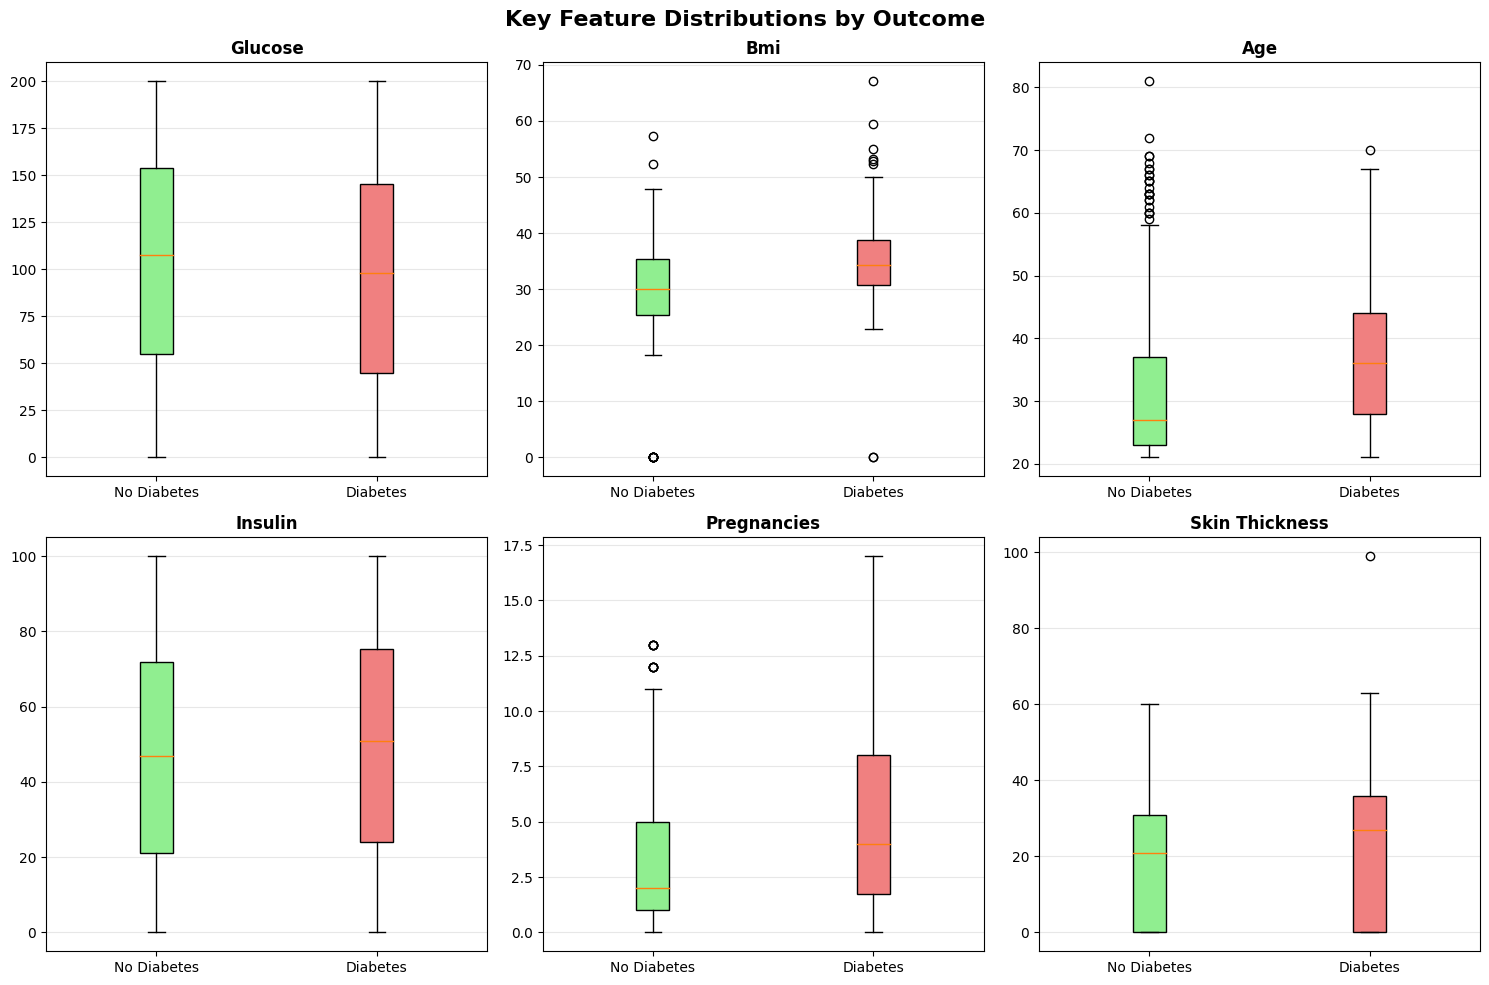

In [45]:
print("\n" + "="*80)
print("FEATURE DISTRIBUTIONS BY OUTCOME")
print("="*80)

# Top features based on correlation
top_features = ['glucose_1', 'bmi', 'age', 'insulin_1', 'pregnancies', 'skin_thickness']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Key Feature Distributions by Outcome', fontsize=16, fontweight='bold')
axes = axes.flatten()

for idx, feature in enumerate(top_features):
    if feature not in df.columns:
        continue
    
    # Split by outcome
    data = [df[df['outcome'] == 0][feature].dropna(),
            df[df['outcome'] == 1][feature].dropna()]
    
    # Box plot
    bp = axes[idx].boxplot(data, labels=['No Diabetes', 'Diabetes'], patch_artist=True)
    bp['boxes'][0].set_facecolor('lightgreen')
    bp['boxes'][1].set_facecolor('lightcoral')
    
    axes[idx].set_title(feature.replace('_1', '').replace('_', ' ').title(), fontweight='bold')
    axes[idx].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Decisions Result:

In [46]:
print("\n" + "="*80)
print("DATA PREPROCESSING DECISIONS")
print("="*80)

print("\n📊 DECISION 1: OUTLIER HANDLING")
print("-" * 60)
print("✅ DECISION: Remove rows with extreme physiologically impossible values")
print("\nRationale:")
print("  • Insulin > 500: Extremely rare, likely measurement errors")
print("  • Glucose > 600: Fatal levels, likely data entry errors")
print("  • Blood Pressure > 200 or < 30: Life-threatening, suspicious")
print("  • BMI > 80 or < 10: Physiologically implausible")
print("\nImpact:")
extreme_insulin = ((df['insulin_1'] > 500).sum() + (df['insulin_13'] > 500).sum())
extreme_glucose = ((df['glucose_1'] > 600).sum() + (df['glucose_13'] > 600).sum())
extreme_bp = (((df['blood_pressure_1'] > 200) | (df['blood_pressure_1'] < 30)).sum() + 
              ((df['blood_pressure_13'] > 200) | (df['blood_pressure_13'] < 30)).sum())
print(f"  • Insulin outliers: {extreme_insulin}")
print(f"  • Glucose outliers: {extreme_glucose}")
print(f"  • Blood pressure outliers: {extreme_bp}")
print(f"  • Expected rows removed: ~{len(df) - 650} (will be calculated during cleaning)")

print("\n📊 DECISION 2: SKIN_THICKNESS")
print("-" * 60)
print("✅ DECISION: KEEP skin_thickness in the model")
print("\nRationale:")
skin_corr = corr_matrix.loc['skin_thickness', 'outcome'] if 'skin_thickness' in corr_matrix.index else 0
print(f"  • Correlation with outcome: {skin_corr:.4f}")
print(f"  • Medical relevance: Skin thickness relates to body fat distribution")
print(f"  • Not redundant: Low correlation with other features")
print("\n⚠️  Note: Although correlation is moderate, skin thickness provides")
print("   unique information about subcutaneous fat that BMI doesn't capture.")

print("\n📊 DECISION 3: MISSING VALUE IMPUTATION")
print("-" * 60)
print("✅ DECISION: Use KNNImputer (k=5) for missing values")
print("\nRationale:")
print("  • KNN considers relationships between features")
print("  • Better than mean/median for medical data")
print("  • Preserves data distribution")
print("  • Uses k=5 neighbors with distance weighting")
print("\nProcess:")
print("  1. Replace zeros with NaN (zeros are missing in medical data)")
print("  2. Remove extreme outliers (set to NaN)")
print("  3. Combine Day 1 and Day 13 measurements")
print("  4. Apply KNNImputer to fill remaining NaN values")

print("\n📊 DECISION 4: FEATURE SCALING")
print("-" * 60)
print("✅ DECISION: Use StandardScaler for all features")
print("\nRationale:")
print("  • Features have different scales (glucose: 0-200, insulin: 0-500)")
print("  • Required for Logistic Regression to work properly")
print("  • Improves Decision Tree performance (though not required)")
print("  • Applied AFTER imputation in the pipeline")


DATA PREPROCESSING DECISIONS

📊 DECISION 1: OUTLIER HANDLING
------------------------------------------------------------
✅ DECISION: Remove rows with extreme physiologically impossible values

Rationale:
  • Insulin > 500: Extremely rare, likely measurement errors
  • Glucose > 600: Fatal levels, likely data entry errors
  • Blood Pressure > 200 or < 30: Life-threatening, suspicious
  • BMI > 80 or < 10: Physiologically implausible

Impact:
  • Insulin outliers: 9
  • Glucose outliers: 0
  • Blood pressure outliers: 216
  • Expected rows removed: ~118 (will be calculated during cleaning)

📊 DECISION 2: SKIN_THICKNESS
------------------------------------------------------------
✅ DECISION: KEEP skin_thickness in the model

Rationale:
  • Correlation with outcome: 0.0748
  • Medical relevance: Skin thickness relates to body fat distribution
  • Not redundant: Low correlation with other features

⚠️  Note: Although correlation is moderate, skin thickness provides
   unique information a

# Preprocessing summary:

In [47]:
print("\n" + "="*80)
print("PREPROCESSING PIPELINE DECISIONS")
print("="*80)

preprocessing_decisions = pd.DataFrame({
    'Step': [
        '1. Zero Handling',
        '2. Outlier Removal',
        '3. Feature Selection',
        '4. Missing Value Imputation',
        '5. Feature Scaling'
    ],
    'Method': [
        'Replace with NaN',
        'Remove extreme values',
        'Keep all features including skin_thickness',
        'KNNImputer (k=5, distance-weighted)',
        'StandardScaler'
    ],
    'Rationale': [
        'Zeros represent missing data in medical measurements',
        'Values outside physiological ranges are measurement errors',
        'Skin thickness shows correlation and provides unique info',
        'Preserves feature relationships better than simple imputation',
        'Required for LogReg, improves model performance'
    ]
})

print("\n", preprocessing_decisions.to_string(index=False))

print("\nAll decisions are based on:")
print("   1. Medical domain knowledge (physiological ranges)")
print("   2. Statistical analysis (correlation, outlier detection)")
print("   3. Machine learning best practices (imputation, scaling)")


PREPROCESSING PIPELINE DECISIONS

                        Step                                     Method                                                     Rationale
           1. Zero Handling                           Replace with NaN          Zeros represent missing data in medical measurements
         2. Outlier Removal                      Remove extreme values    Values outside physiological ranges are measurement errors
       3. Feature Selection Keep all features including skin_thickness     Skin thickness shows correlation and provides unique info
4. Missing Value Imputation        KNNImputer (k=5, distance-weighted) Preserves feature relationships better than simple imputation
         5. Feature Scaling                             StandardScaler               Required for LogReg, improves model performance

All decisions are based on:
   1. Medical domain knowledge (physiological ranges)
   2. Statistical analysis (correlation, outlier detection)
   3. Machine learning 

## Creating Pipelines

### Create Custom Transformers:

In [48]:
class ZeroToNaNTransformer(BaseEstimator, TransformerMixin):
    """Replace zeros with NaN for specified columns"""
    
    def __init__(self, columns=None):
        self.columns = columns
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        cols = self.columns if self.columns else X.columns
        for col in cols:
            if col in X.columns:
                X.loc[X[col] == 0, col] = np.nan
        return X

In [49]:
class ExtremValueRemoverTransformer(BaseEstimator, TransformerMixin):
    """
    Remove physiologically impossible values (set to NaN)
    These will be imputed later
    """
    
    def __init__(self, extreme_ranges=None):
        """
        extreme_ranges: dict like {'insulin': (0, 500), 'glucose': (30, 600)}
        Values outside these ranges are set to NaN
        """
        self.extreme_ranges = extreme_ranges or {}
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        
        for col, (min_val, max_val) in self.extreme_ranges.items():
            if col in X.columns:
                X.loc[(X[col] < min_val) | (X[col] > max_val), col] = np.nan
        
        return X

Helper function to combine day 1 and day13 measurements


In [50]:

def combine_measurement_columns(df, measure_names=['glucose', 'insulin', 'blood_pressure']):
    """
    Coalesce day 1 and day 13 columns BEFORE splitting
    This is data preparation, not transformation
    """
    df = df.copy()
    
    for measure in measure_names:
        day1_col = f'{measure}_1'
        day13_col = f'{measure}_13'
        result_col = measure
        
        if day1_col not in df.columns or day13_col not in df.columns:
            continue
        
        # Get the data
        day1 = df[day1_col]
        day13 = df[day13_col]
        
        # Pattern detection
        both_present = day1.notna() & day13.notna()
        day1_only = day1.notna() & day13.isna()
        day13_only = day1.isna() & day13.notna()
        
        # Apply strategy
        df[result_col] = np.nan
        df.loc[day1_only, result_col] = day1[day1_only]
        df.loc[day13_only, result_col] = day13[day13_only]
        df.loc[both_present, result_col] = (day1[both_present] + day13[both_present]) / 2
        
        # Drop old columns
        df.drop(columns=[day1_col, day13_col], inplace=True)
        
        print(f"Combined {measure}: {df[result_col].notna().sum()} non-null values")
    
    return df

## Apply Combine Measurement Columns:

In [51]:
print("\n" + "="*80)
print("STEP 1: Coalescing Day 1 and Day 13 Columns (Before Split)")
print("="*80)

df_combined = combine_measurement_columns(df)
print(f"Shape after coalescing: {df_combined.shape}")


STEP 1: Coalescing Day 1 and Day 13 Columns (Before Split)
Combined glucose: 768 non-null values
Combined insulin: 768 non-null values
Combined blood_pressure: 768 non-null values
Shape after coalescing: (768, 10)


## Separate Features and Target:

In [52]:
print("\n" + "="*80)
print("STEP 2: Separating Features and Target")
print("="*80)

# Drop patient_id (not a feature)
if 'patient_id' in df_combined.columns:
    df_combined = df_combined.drop(columns=['patient_id'])

# Separate features and target
X = df_combined.drop(columns=['outcome'])
y = df_combined['outcome']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Target distribution: {y.value_counts().to_dict()}")


STEP 2: Separating Features and Target
Features shape: (768, 8)
Target shape: (768,)
Target distribution: {0: 500, 1: 268}


## Split Data to Train/Test

In [65]:
print("\n" + "="*80)
print("STEP 3: Train/Test Split")
print("="*80)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.25, 
    random_state=42, 
    stratify=y  # Maintain class balance
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Train target distribution: {y_train.value_counts().to_dict()}")
print(f"Test target distribution: {y_test.value_counts().to_dict()}")


STEP 3: Train/Test Split
Training set: (576, 8)
Test set: (192, 8)
Train target distribution: {0: 375, 1: 201}
Test target distribution: {0: 125, 1: 67}


## Create Preprocessor:

In [66]:
print("\n" + "="*80)
print("STEP 4: Creating Preprocessing Pipeline")
print("="*80)

# Define column groups
numeric_cols = ['glucose', 'insulin', 'blood_pressure', 'bmi', 
                'skin_thickness', 'age', 'diabetes_pedigree_function']
categorical_cols = ['pregnancies']  # Treat pregnancies as categorical

zero_to_nan_cols = ['glucose', 'insulin', 'blood_pressure', 'bmi', 'skin_thickness']

extreme_ranges = {
    'insulin': (0, 500),
    'glucose': (30, 600),
    'blood_pressure': (30, 200),
    'bmi': (10, 80)
}

# Create numeric pipeline
numeric_pipeline = Pipeline([
    ('zero_to_nan', ZeroToNaNTransformer(columns=zero_to_nan_cols)),
    ('extreme_remover', ExtremValueRemoverTransformer(extreme_ranges=extreme_ranges)),
    ('imputer', KNNImputer(n_neighbors=5, weights='distance')),
    ('scaler', StandardScaler())
])

# Create categorical pipeline
categorical_pipeline = Pipeline([
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

# Combine pipelines
preprocessor = ColumnTransformer([
    ('numeric', numeric_pipeline, numeric_cols),
    ('categorical', categorical_pipeline, categorical_cols)
], remainder='passthrough')  # Keep any other columns as-is


# print("Pipeline steps:")
# for i, (name, transformer) in enumerate(preprocessor.steps, 1):
#     print(f"  {i}. {name}: {transformer.__class__.__name__}")


STEP 4: Creating Preprocessing Pipeline


# Logistics Regression:

In [79]:
print("\n" + "="*80)
print("1. LOGISTIC REGRESSION")
print("="*80)

# Build pipeline with LogisticRegression
pipe_logreg = Pipeline([
    ('preprocessor', preprocessor),
    ('logreg', LogisticRegression(random_state=42))
])

# Quick cross-validation check (before grid search)
print("\nInitial Cross-Validation (with default parameters):")
print("-" * 60)
y_train_predicted_logreg = cross_val_predict(pipe_logreg, X_train, y_train, cv=5)

print("Accuracy:  {:.4f}".format(accuracy_score(y_train, y_train_predicted_logreg)))
print("Recall:    {:.4f}".format(recall_score(y_train, y_train_predicted_logreg)))
print("Precision: {:.4f}".format(precision_score(y_train, y_train_predicted_logreg)))
print("F1 Score:  {:.4f}".format(f1_score(y_train, y_train_predicted_logreg)))

# Define parameter grid for Logistic Regression
param_logreg = {
    'logreg__penalty':('l1','l2'),
    'logreg__C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0],
    'logreg__solver': ['liblinear', 'lbfgs', 'sag', 'saga'],
    'logreg__class_weight': [None, 'balanced'],
    'logreg__max_iter': [100, 500, 1000, 5000, 10000]
}

# Grid Search for Logistic Regression
print("\nRunning Grid Search for Logistic Regression...")
print("-" * 60)

grid_logreg = GridSearchCV(
    pipe_logreg, 
    param_grid=param_logreg, 
    cv=5, 
    scoring='f1',  # Using F1 score (good for imbalanced data)
    verbose=2, 
    n_jobs=-1
)

grid_logreg.fit(X_train, y_train)

# Results for Logistic Regression
print("\n" + "="*60)
print("LOGISTIC REGRESSION - GRID SEARCH RESULTS")
print("="*60)
print('Best CV Score: {:.4f}'.format(grid_logreg.best_score_))
print("Best Parameters:")
for param, value in grid_logreg.best_params_.items():
    print(f"  {param}: {value}")

# Save best Logistic Regression model
best_model_logreg = grid_logreg.best_estimator_


1. LOGISTIC REGRESSION

Initial Cross-Validation (with default parameters):
------------------------------------------------------------
Accuracy:  0.7170
Recall:    0.4577
Precision: 0.6301
F1 Score:  0.5303

Running Grid Search for Logistic Regression...
------------------------------------------------------------
Fitting 5 folds for each of 640 candidates, totalling 3200 fits

LOGISTIC REGRESSION - GRID SEARCH RESULTS
Best CV Score: 0.6106
Best Parameters:
  logreg__C: 0.1
  logreg__class_weight: balanced
  logreg__max_iter: 100
  logreg__penalty: l1
  logreg__solver: liblinear


# Decision Tree:

In [86]:
print("\n" + "="*80)
print("2. DECISION TREE CLASSIFIER")
print("="*80)

# Build pipeline with DecisionTreeClassifier
pipe_dt = Pipeline([
    ('preprocessor', preprocessor),
    ('dt', DecisionTreeClassifier(random_state=42))
])

# Quick cross-validation check (before grid search)
print("\nInitial Cross-Validation (with default parameters):")
print("-" * 60)
y_train_predicted_dt = cross_val_predict(pipe_dt, X_train, y_train, cv=5)

print("Accuracy:  {:.4f}".format(accuracy_score(y_train, y_train_predicted_dt)))
print("Recall:    {:.4f}".format(recall_score(y_train, y_train_predicted_dt)))
print("Precision: {:.4f}".format(precision_score(y_train, y_train_predicted_dt)))
print("F1 Score:  {:.4f}".format(f1_score(y_train, y_train_predicted_dt)))

# Define parameter grid for Decision Tree
param_dt = {
    'dt__criterion': ['gini', 'entropy', 'log_loss'],
    'dt__max_depth': [1, 2, 3, 4, 5, 6, 7, 9, 10, 15, None],
    'dt__min_samples_split': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20],
    'dt__min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'dt__max_features': ['auto', 'sqrt', 'log2', None]
}

# Grid Search for Decision Tree
print("\nRunning Grid Search for Decision Tree...")
print("-" * 60)

grid_dt = GridSearchCV(
    pipe_dt, 
    param_grid=param_dt, 
    cv=5, 
    scoring='f1',
    verbose=2, 
    n_jobs=-1
)

grid_dt.fit(X_train, y_train)

# Results for Decision Tree
print("\n" + "="*60)
print("DECISION TREE - GRID SEARCH RESULTS")
print("="*60)
print('Best CV Score: {:.4f}'.format(grid_dt.best_score_))
print("Best Parameters:")
for param, value in grid_dt.best_params_.items():
    print(f"  {param}: {value}")

# Save best Decision Tree model
best_model_dt = grid_dt.best_estimator_



2. DECISION TREE CLASSIFIER

Initial Cross-Validation (with default parameters):
------------------------------------------------------------
Accuracy:  0.6424
Recall:    0.4826
Precision: 0.4874
F1 Score:  0.4850

Running Grid Search for Decision Tree...
------------------------------------------------------------
Fitting 5 folds for each of 15840 candidates, totalling 79200 fits

DECISION TREE - GRID SEARCH RESULTS
Best CV Score: 0.5921
Best Parameters:
  dt__criterion: gini
  dt__max_depth: 2
  dt__max_features: None
  dt__min_samples_leaf: 1
  dt__min_samples_split: 2


# Training Result Comparison:

In [87]:
print("\n" + "="*80)
print("3. TRAINING RESULTS COMPARISON")
print("="*80)

comparison_train = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree'],
    'Best CV Score (F1)': [grid_logreg.best_score_, grid_dt.best_score_]
})

print("\n", comparison_train.to_string(index=False))


3. TRAINING RESULTS COMPARISON

               Model  Best CV Score (F1)
Logistic Regression            0.610575
      Decision Tree            0.592110


# Final Evaluation on Test Set:

In [81]:
print("\n" + "="*80)
print("4. FINAL EVALUATION ON TEST SET")
print("="*80)

# Logistic Regression on Test Set
print("\n" + "-"*60)
print("LOGISTIC REGRESSION - Test Set Performance")
print("-"*60)

y_test_pred_logreg = best_model_logreg.predict(X_test)

logreg_test_acc = accuracy_score(y_test, y_test_pred_logreg)
logreg_test_rec = recall_score(y_test, y_test_pred_logreg)
logreg_test_prec = precision_score(y_test, y_test_pred_logreg)
logreg_test_f1 = f1_score(y_test, y_test_pred_logreg)

print("Accuracy:  {:.4f}".format(logreg_test_acc))
print("Recall:    {:.4f}".format(logreg_test_rec))
print("Precision: {:.4f}".format(logreg_test_prec))
print("F1 Score:  {:.4f}".format(logreg_test_f1))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred_logreg))

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred_logreg))


4. FINAL EVALUATION ON TEST SET

------------------------------------------------------------
LOGISTIC REGRESSION - Test Set Performance
------------------------------------------------------------
Accuracy:  0.6927
Recall:    0.7015
Precision: 0.5465
F1 Score:  0.6144

Confusion Matrix:
[[86 39]
 [20 47]]

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.69      0.74       125
           1       0.55      0.70      0.61        67

    accuracy                           0.69       192
   macro avg       0.68      0.69      0.68       192
weighted avg       0.72      0.69      0.70       192



In [82]:
# Decision Tree on Test Set
print("\n" + "-"*60)
print("DECISION TREE - Test Set Performance")
print("-"*60)

y_test_pred_dt = best_model_dt.predict(X_test)

dt_test_acc = accuracy_score(y_test, y_test_pred_dt)
dt_test_rec = recall_score(y_test, y_test_pred_dt)
dt_test_prec = precision_score(y_test, y_test_pred_dt)
dt_test_f1 = f1_score(y_test, y_test_pred_dt)

print("Accuracy:  {:.4f}".format(dt_test_acc))
print("Recall:    {:.4f}".format(dt_test_rec))
print("Precision: {:.4f}".format(dt_test_prec))
print("F1 Score:  {:.4f}".format(dt_test_f1))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred_dt))

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred_dt))


------------------------------------------------------------
DECISION TREE - Test Set Performance
------------------------------------------------------------
Accuracy:  0.6823
Recall:    0.5970
Precision: 0.5405
F1 Score:  0.5674

Confusion Matrix:
[[91 34]
 [27 40]]

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.73      0.75       125
           1       0.54      0.60      0.57        67

    accuracy                           0.68       192
   macro avg       0.66      0.66      0.66       192
weighted avg       0.69      0.68      0.69       192



# Final Comparison:

In [83]:
print("\n" + "="*80)
print("5. FINAL COMPARISON - TEST SET RESULTS")
print("="*80)

final_results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree'],
    'Accuracy': [logreg_test_acc, dt_test_acc],
    'Precision': [logreg_test_prec, dt_test_prec],
    'Recall': [logreg_test_rec, dt_test_rec],
    'F1 Score': [logreg_test_f1, dt_test_f1]
})

print("\n", final_results.round(4).to_string(index=False))

# Determine best model
best_model_name = final_results.loc[final_results['F1 Score'].idxmax(), 'Model']
best_f1_score = final_results['F1 Score'].max()

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   F1 Score: {best_f1_score:.4f}")

# Save the best overall model
if best_model_name == 'Logistic Regression':
    final_best_model = best_model_logreg
else:
    final_best_model = best_model_dt

print(f"\nBest model saved as 'final_best_model'")


5. FINAL COMPARISON - TEST SET RESULTS

               Model  Accuracy  Precision  Recall  F1 Score
Logistic Regression    0.6927     0.5465  0.7015    0.6144
      Decision Tree    0.6823     0.5405  0.5970    0.5674

🏆 BEST MODEL: Logistic Regression
   F1 Score: 0.6144

Best model saved as 'final_best_model'


# Visualization Comparizon:


6. CREATING VISUALIZATIONS


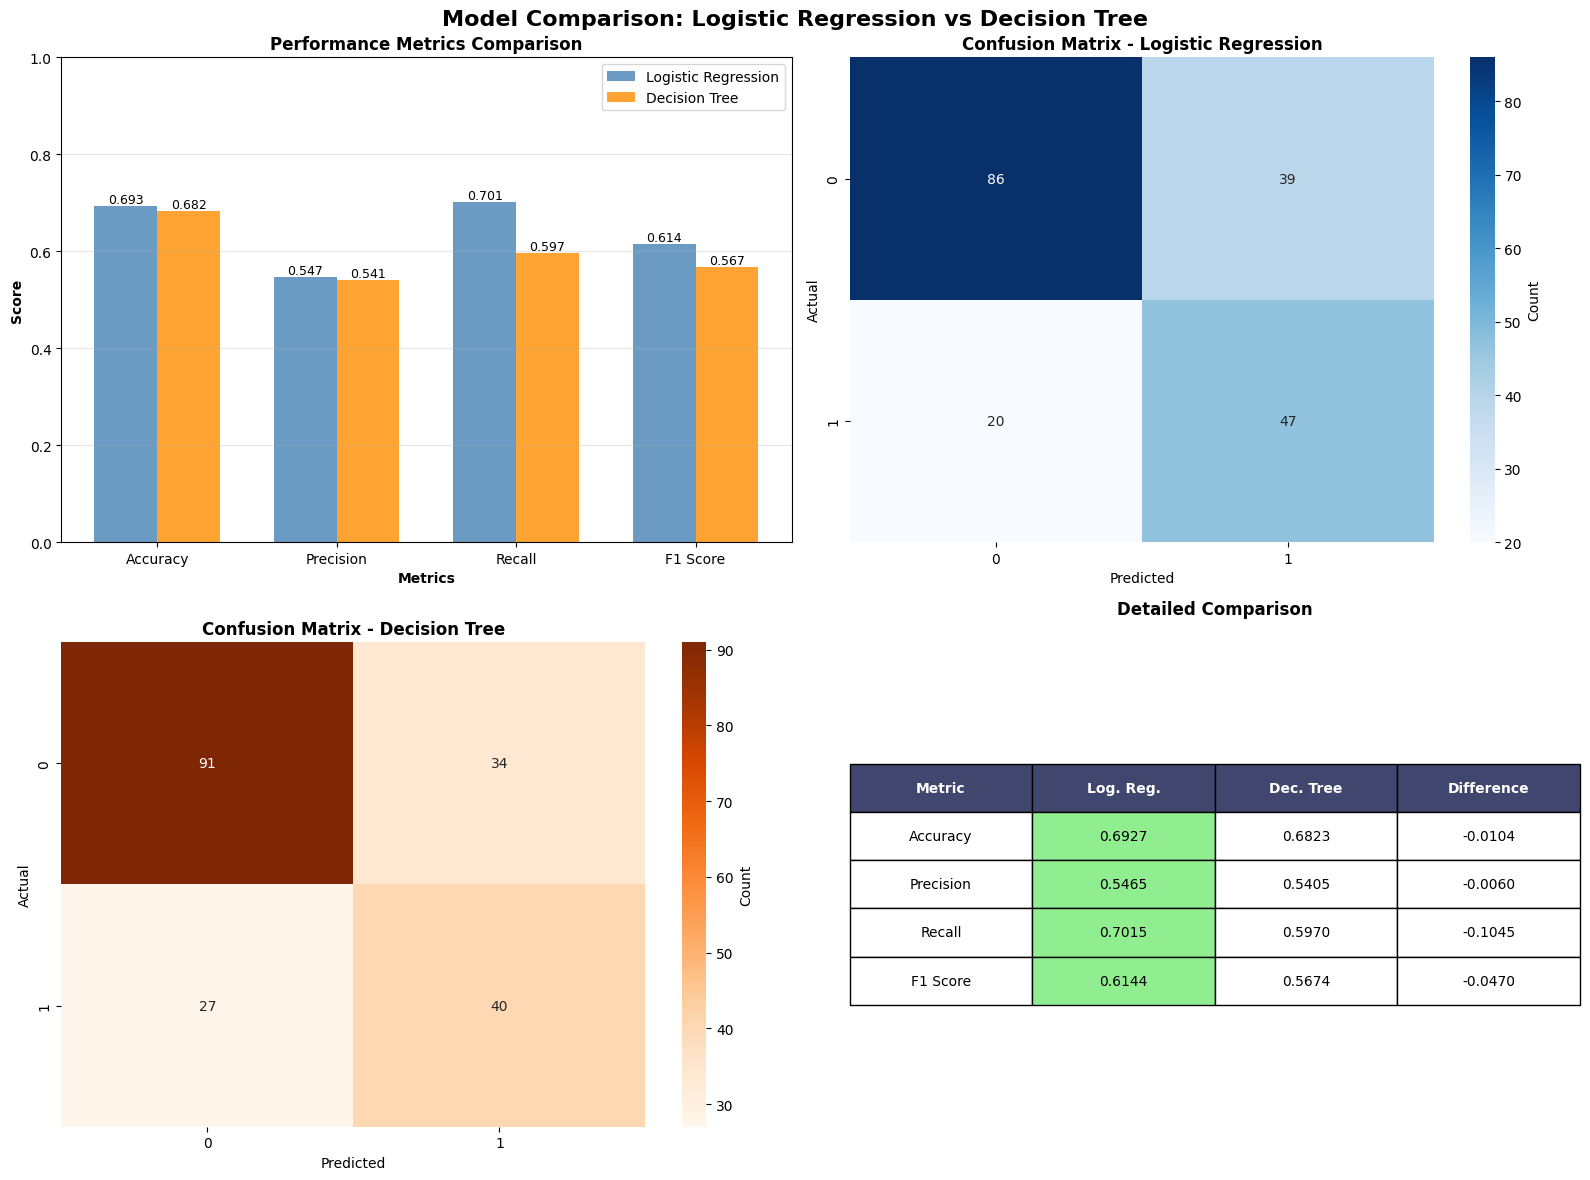

In [84]:
print("\n" + "="*80)
print("6. CREATING VISUALIZATIONS")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Model Comparison: Logistic Regression vs Decision Tree', 
             fontsize=16, fontweight='bold')

# Plot 1: Bar chart of metrics
ax1 = axes[0, 0]
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
x = np.arange(len(metrics))
width = 0.35

logreg_scores = [logreg_test_acc, logreg_test_prec, logreg_test_rec, logreg_test_f1]
dt_scores = [dt_test_acc, dt_test_prec, dt_test_rec, dt_test_f1]

bars1 = ax1.bar(x - width/2, logreg_scores, width, label='Logistic Regression', 
                color='steelblue', alpha=0.8)
bars2 = ax1.bar(x + width/2, dt_scores, width, label='Decision Tree', 
                color='darkorange', alpha=0.8)

ax1.set_xlabel('Metrics', fontweight='bold')
ax1.set_ylabel('Score', fontweight='bold')
ax1.set_title('Performance Metrics Comparison', fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics)
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_ylim([0, 1])

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

# Plot 2: Confusion Matrix - Logistic Regression
ax2 = axes[0, 1]
cm_logreg = confusion_matrix(y_test, y_test_pred_logreg)
sns.heatmap(cm_logreg, annot=True, fmt='d', cmap='Blues', ax=ax2, 
            cbar_kws={'label': 'Count'})
ax2.set_title('Confusion Matrix - Logistic Regression', fontweight='bold')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')

# Plot 3: Confusion Matrix - Decision Tree
ax3 = axes[1, 0]
cm_dt = confusion_matrix(y_test, y_test_pred_dt)
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Oranges', ax=ax3, 
            cbar_kws={'label': 'Count'})
ax3.set_title('Confusion Matrix - Decision Tree', fontweight='bold')
ax3.set_xlabel('Predicted')
ax3.set_ylabel('Actual')

# Plot 4: Comparison table
ax4 = axes[1, 1]
ax4.axis('tight')
ax4.axis('off')

table_data = [
    ['Metric', 'Log. Reg.', 'Dec. Tree', 'Difference'],
    ['Accuracy', f'{logreg_test_acc:.4f}', f'{dt_test_acc:.4f}', 
     f'{dt_test_acc - logreg_test_acc:+.4f}'],
    ['Precision', f'{logreg_test_prec:.4f}', f'{dt_test_prec:.4f}', 
     f'{dt_test_prec - logreg_test_prec:+.4f}'],
    ['Recall', f'{logreg_test_rec:.4f}', f'{dt_test_rec:.4f}', 
     f'{dt_test_rec - logreg_test_rec:+.4f}'],
    ['F1 Score', f'{logreg_test_f1:.4f}', f'{dt_test_f1:.4f}', 
     f'{dt_test_f1 - logreg_test_f1:+.4f}']
]

table = ax4.table(cellText=table_data, cellLoc='center', loc='center',
                 colWidths=[0.25, 0.25, 0.25, 0.25])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.5)

# Header styling
for i in range(4):
    table[(0, i)].set_facecolor('#40466e')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Highlight best scores
for i in range(1, 5):
    logreg_val = float(table_data[i][1])
    dt_val = float(table_data[i][2])
    if logreg_val > dt_val:
        table[(i, 1)].set_facecolor('#90EE90')  # Light green
    elif dt_val > logreg_val:
        table[(i, 2)].set_facecolor('#90EE90')

ax4.set_title('Detailed Comparison', fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

# Best Model:

In [85]:
print("\n" + "="*80)
print("8. BEST MODEL DETAILS")
print("="*80)

print("\nLogistic Regression Best Estimator:")
print("-" * 60)
print(best_model_logreg)

print("\n\nDecision Tree Best Estimator:")
print("-" * 60)
print(best_model_dt)

# For Decision Tree, you can also visualize it
if best_model_name == 'Decision Tree':
    from sklearn.tree import plot_tree
    
    fig, ax = plt.subplots(figsize=(20, 10))
    plot_tree(best_model_dt.named_steps['dt'], 
              feature_names=X_train.columns,
              class_names=['No Diabetes', 'Diabetes'],
              filled=True, 
              rounded=True,
              ax=ax,
              fontsize=10)
    plt.title('Best Decision Tree Visualization', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()


8. BEST MODEL DETAILS

Logistic Regression Best Estimator:
------------------------------------------------------------
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric',
                                                  Pipeline(steps=[('zero_to_nan',
                                                                   ZeroToNaNTransformer(columns=['glucose',
                                                                                                 'insulin',
                                                                                                 'blood_pressure',
                                                                                                 'bmi',
                                                                                                 'skin_thickness'])),
                                                                  ('extreme_remover',
    